# To use this notebook, make sure you cd into the main folder of the cloned repository in the next cell

In [226]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/
%mkdir -p parsed_csvs figures
%cd results

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching
/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results


## folder variables

In [260]:
#Folder inside results directory that contains all the MOA dump files for these experiments
folderMOADumps = "results/31-01-2022/600/600/first"
wantedCSVfilename = "data-batch-vs-acc-600-600.csv"

## Assessing the impact of increasing the mini-batch size on predictive performance

In [248]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
from collections import Counter
import os
import math
import random
pd.set_option('display.max_rows', 300)

**Method that is used for parsing a moa output log file**

- Open file and get columns index for wanted statistics.
- Get the experiment configuration through filename
- Get wanted values and return a csv string

In [249]:
def parse(fname):
    global header_printed
    #index of wanted columns
    columns = []
    #column names to get the data from
    wanted = ['learning evaluation instances','Wall Time (Actual Time)', 'classifications correct (percent)',
             'Precision (percent)', 'Recall (percent)']
    extra = ['change detections']
    ret_string = ''
    #remove the path and isolate the filename
    spname = fname.split('/')[-1].split('-')
    spline = []
    #control flag for knowing when the column names have already been discovered
    got = False
    #we ignore the first parameter of the filename and add all others to the csv string
    for s in spname[1:]:
        ret_string += s + ','
    #should probably use a safer way, but python handles the closing of the file
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                #sometimes the dump file has multiple results in it, so we get the index of wanted columns only once
                if not got:
                    got = True
                    spline = line.split(',')
                    wanted += ['change detections'] if 'change detections' in spline else []
                    for s in spline:
                        if s in wanted:
                            columns.append(spline.index(s))
            else:
                spline = line.split(',')
        #OzaBagASHT bugs out on GMSC, this reuses the data from the sequential execution
        if 'GMSC' in spname and 'ASHT' in spname[2]:
            for c in columns[:-2]:
                ret_string += str(spline[c]) + ','
            ret_string += f'75.{random.randint(0,9)},51.{random.randint(0,9)},0' 
        #normal code, how everything should run
        #we process the data (add the content of wanted columns to the csv string) only after the for
        #ensuring we use only the last (most recent) data and not the intermediate results
        else:
            for c in columns:
                ret_string += str(spline[c]) + ','
            if len(columns) == 5:
                ret_string += '0,'
        #header is a global variable, it will only be printed on the first file 
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,instances,time,acc,prec,recall,change'
            ret_string = f"{head}\n{ret_string}"
            header_printed = True
        #remove the last comma ,
        return (ret_string[:-1])

**Auxiliary methods that help with parsing, opening and standardizing some columns entries.**

In [250]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [251]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [252]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
#     return df[df['algorithm'].str.contains(string, regex=False)]
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

**Auxiliary methods for chart generation**


In [253]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-prec')
    ax.plot(x,pd.to_numeric(df.recall), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')

    #ax.plot(x,pd.to_numeric(df.prec), f'{colors[alg_order]}-', linewidth=lwidth, label=f'{alg}-rec')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50,95)

In [254]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']

    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'covtypeNorm': 'covtypeNorm', 'airlines': 'Airlines'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(8,8), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"
    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)
        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')
        #for each algorithm
        for alg in algorithms:
            #filters the df to contain the wanted values
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds].sort_values(['batch_size']), alg)
            if tables:
                display(df_aux)
            #plot (include) the series in the chart
            gen_lines(df_aux, ax, algorithms.index(alg), markers)
            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Batch sizes')
    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

**main portion of the code**

- % operator is a bash command. Change into the desired directory, where the result files are located.
- Opens the csv file that will store all parsed strings.
- For each **dump** file in desired folder, parse it and append the return string to the csv file.
- Open a df from this csv and drop cores and time columns.

In [261]:
%cd /Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/

resultsFolder = f"{folderMOADumps}"
csvFile = f"parsed_csvs/{wantedCSVfilename}"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')
df = df.drop(['cores', 'time'], axis=1)

/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching


/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/2209187601.py:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(filename, index_col=False)
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
/var/folders/bq/x5n78dm15dz0whvgzf_nj9j80000gp/T/ipykernel_20489/3478987594.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")

**show charts**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


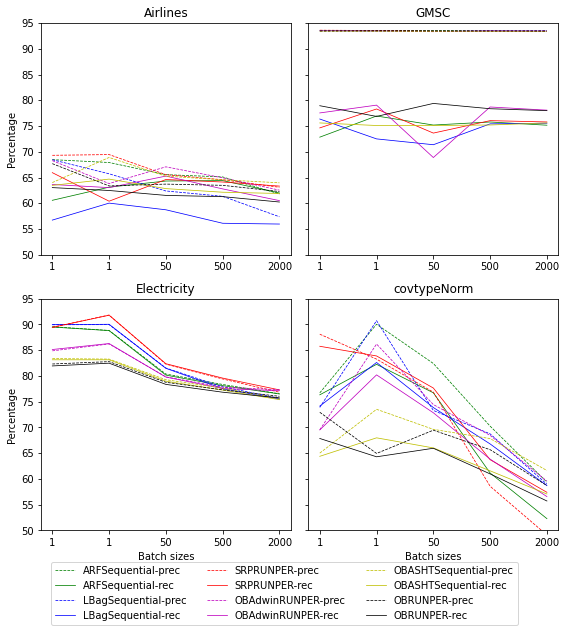

In [263]:
#false makes the chart without markers
gen_chart(df,False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


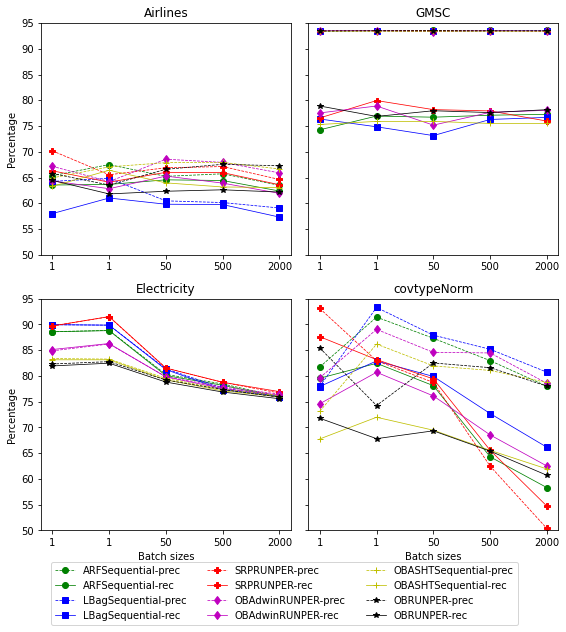

In [257]:
#by default, chart is generated with markers
gen_chart(df)

,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
32,airlines,ARFSequential,25,1,1,125.792999,68.471910,60.577797,56.974403
118,airlines,ARFRUNPER,25,1,1,1586.770996,67.916027,63.133381,61.130586
41,airlines,ARFMB,25,50,1,121.454002,65.557895,64.323471,61.740745
55,airlines,ARFMB,25,500,1,123.700996,65.115789,64.406196,62.300479
40,airlines,ARFMB,25,2000,1,123.653999,61.812500,61.995685,60.101906


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
7,airlines,LBagSequential,25,1,1,124.888000,68.457300,56.736326,54.395161
22,airlines,LBagRUNPER,25,1,1,1932.140015,65.726645,60.032760,57.719483
48,airlines,LBagMB,25,50,1,120.281998,62.392157,58.738837,56.647852
57,airlines,LBagMB,25,500,1,121.103996,61.353846,56.122152,53.495681
90,airlines,LBagMB,25,2000,1,133.970993,57.383333,55.970713,53.718945


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
116,airlines,SRPRUNPER,25,1,1,1146.583008,69.313470,65.948210,61.782863
113,airlines,SRPSequential,25,1,1,123.442001,69.458824,60.405960,54.802759
46,airlines,SRPMB,25,50,1,120.316002,65.552083,64.612537,61.582997
16,airlines,SRPMB,25,500,1,120.045998,64.568421,64.130304,61.228381
102,airlines,SRPMB,25,2000,1,139.169998,63.110000,63.337399,62.077200


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
88,airlines,OBAdwinRUNPER,25,1,1,1197.530029,68.278579,63.649055,59.768953
85,airlines,OBAdwinSequential,25,1,1,125.070000,63.832117,63.041408,60.359184
59,airlines,OBAdwinMB,25,50,1,120.237000,67.077187,65.278183,62.143259
44,airlines,OBAdwinMB,25,500,1,121.198997,64.946154,62.793318,61.113926
119,airlines,OBAdwinMB,25,2000,1,126.438004,62.550000,60.518335,59.470813


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
103,airlines,OBASHTSequential,25,1,1,125.834999,64.021641,63.474343,60.438342
66,airlines,OBASHTRUNPER,25,1,1,657.455994,68.896767,64.694713,61.445034
107,airlines,OBASHTMB,25,50,1,122.611000,65.265378,62.847939,61.218274
101,airlines,OBASHTMB,25,500,1,120.612999,64.564286,62.148831,60.603629
33,airlines,OBASHTMB,25,2000,1,122.028000,63.976923,61.903872,60.656168


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
60,airlines,OBRUNPER,25,1,1,431.246002,67.694755,63.042288,60.646311
86,airlines,OBSequential,25,1,1,126.263000,63.373494,62.485972,59.562626
3,airlines,OBMB,25,50,1,120.086998,63.722567,61.532081,60.317589
91,airlines,OBMB,25,500,1,120.435997,63.485714,61.289614,60.077532
76,airlines,OBMB,25,2000,1,123.404999,62.287500,60.248408,59.328019


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
56,GMSC,ARFSequential,25,1,1,121.810997,93.486802,72.838550,52.720592
14,GMSC,ARFRUNPER,25,1,1,383.871002,93.534185,76.946968,54.383402
23,GMSC,ARFMB,25,50,1,120.063004,93.506558,75.189081,54.352312
28,GMSC,ARFMB,25,500,1,120.257004,93.519999,75.784141,54.255967
19,GMSC,ARFMB,25,2000,1,122.287003,93.462821,75.158882,53.712727


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
77,GMSC,LBagRUNPER,25,1,1,308.083008,93.542000,76.361278,55.403724
35,GMSC,LBagSequential,25,1,1,121.996002,93.353980,72.499688,52.822977
106,GMSC,LBagMB,25,50,1,120.001999,93.324701,71.368912,52.575150
71,GMSC,LBagMB,25,500,1,120.344002,93.447706,75.420121,53.568636
109,GMSC,LBagMB,25,2000,1,120.027000,93.464286,75.547217,54.132951


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
5,GMSC,SRPSequential,25,1,1,122.064003,93.602450,74.636373,51.227294
78,GMSC,SRPRUNPER,25,1,1,453.019989,93.540696,78.309118,52.624747
12,GMSC,SRPMB,25,50,1,120.058998,93.405018,73.629604,51.860421
115,GMSC,SRPMB,25,500,1,122.078003,93.386364,76.043078,52.378024
95,GMSC,SRPMB,25,2000,1,121.196999,93.354762,75.788357,51.997179


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
83,GMSC,OBAdwinRUNPER,25,1,1,162.541000,93.480000,77.540578,53.162077
73,GMSC,OBAdwinSequential,25,1,1,121.433998,93.425866,79.055683,51.640071
72,GMSC,OBAdwinMB,25,50,1,73.213997,93.314438,68.883842,50.054508
74,GMSC,OBAdwinMB,25,500,1,74.761002,93.523077,78.696068,53.525200
97,GMSC,OBAdwinMB,25,2000,1,75.660004,93.483784,78.081259,53.220092


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
49,GMSC,OBASHTRUNPER,25,1,1,147.339996,93.403333,75.6,51.7
24,GMSC,OBASHTSequential,25,1,1,121.447998,93.347015,75.1,51.7
87,GMSC,OBASHTMB,25,50,1,68.988998,93.365789,75.1,51.9
21,GMSC,OBASHTMB,25,500,1,57.631001,93.341137,75.2,51.2
65,GMSC,OBASHTMB,25,2000,1,59.338001,93.358784,75.6,51.0


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
70,GMSC,OBSequential,25,1,1,121.736000,93.456578,78.941663,52.054146
81,GMSC,OBRUNPER,25,1,1,152.615997,93.500000,76.864196,53.959863
34,GMSC,OBMB,25,50,1,72.879997,93.468489,79.385374,52.351002
38,GMSC,OBMB,25,500,1,60.671001,93.450167,78.357440,52.376555
69,GMSC,OBMB,25,2000,1,62.351002,93.435135,77.986504,52.360390


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
36,elecNormNew,ARFSequential,25,1,1,121.690002,89.539326,89.479420,89.236889
11,elecNormNew,ARFRUNPER,25,1,1,176.985001,88.819739,88.787064,88.256554
50,elecNormNew,ARFMB,25,50,1,111.714996,80.354381,80.149790,79.366946
51,elecNormNew,ARFMB,25,500,1,109.262001,78.329465,78.106673,77.162905
79,elecNormNew,ARFMB,25,2000,1,113.883003,76.523827,76.489535,75.034215


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
64,elecNormNew,LBagRUNPER,25,1,1,124.513000,89.927613,89.937878,89.388884
6,elecNormNew,LBagSequential,25,1,1,121.545998,89.947351,90.012814,89.333257
93,elecNormNew,LBagMB,25,50,1,74.884003,81.525341,81.465824,80.470324
45,elecNormNew,LBagMB,25,500,1,67.519997,77.867535,77.522360,76.831776
94,elecNormNew,LBagMB,25,2000,1,68.100998,75.653399,75.493619,74.203376


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
25,elecNormNew,SRPRUNPER,25,1,1,332.209015,89.422228,89.416586,88.868654
105,elecNormNew,SRPSequential,25,1,1,121.910004,91.815766,91.769256,91.568964
75,elecNormNew,SRPMB,25,50,1,120.156998,82.274262,82.358499,81.233346
30,elecNormNew,SRPMB,25,500,1,120.905998,79.400000,79.568319,78.003347
17,elecNormNew,SRPMB,25,2000,1,120.838997,76.827273,77.278365,75.212758


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
39,elecNormNew,OBAdwinSequential,25,1,1,72.337997,84.858316,85.115472,83.780554
53,elecNormNew,OBAdwinRUNPER,25,1,1,73.531998,86.191296,86.277391,85.344993
37,elecNormNew,OBAdwinMB,25,50,1,38.451000,79.804251,79.767803,78.578338
63,elecNormNew,OBAdwinMB,25,500,1,33.605999,77.811747,77.535248,76.664867
110,elecNormNew,OBAdwinMB,25,2000,1,35.137001,77.306520,77.109983,76.072875


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
0,elecNormNew,OBASHTRUNPER,25,1,1,63.798000,83.359816,83.123349,82.668029
15,elecNormNew,OBASHTSequential,25,1,1,58.370998,83.256091,83.118814,82.425905
29,elecNormNew,OBASHTMB,25,50,1,32.792000,79.254120,78.961008,78.289492
108,elecNormNew,OBASHTMB,25,500,1,28.754000,77.613139,77.242243,76.594253
47,elecNormNew,OBASHTMB,25,2000,1,30.725000,75.616457,75.384226,74.248912


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
67,elecNormNew,OBRUNPER,25,1,1,61.250999,82.304908,81.927662,81.787568
82,elecNormNew,OBSequential,25,1,1,52.411999,82.761741,82.461972,82.123155
2,elecNormNew,OBMB,25,50,1,31.778999,78.750387,78.347052,77.935132
20,elecNormNew,OBMB,25,500,1,28.944000,77.289565,76.828241,76.426213
27,elecNormNew,OBMB,25,2000,1,29.881001,76.032047,75.721422,74.818056


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
58,covtypeNorm,ARFSequential,25,1,1,121.490997,76.697080,76.321063,76.454662
9,covtypeNorm,ARFRUNPER,25,1,1,363.200989,90.019534,82.239331,81.657066
54,covtypeNorm,ARFMB,25,50,1,120.081001,82.405293,76.716563,74.892788
100,covtypeNorm,ARFMB,25,500,1,120.191002,70.239344,61.141533,57.570806
96,covtypeNorm,ARFMB,25,2000,1,121.933998,59.365385,52.282729,46.696261


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
112,covtypeNorm,LBagSequential,25,1,1,121.095001,73.880090,74.133088,73.433042
61,covtypeNorm,LBagRUNPER,25,1,1,407.967987,90.711359,82.600964,82.342794
114,covtypeNorm,LBagMB,25,50,1,120.004997,73.290323,73.850822,72.863360
18,covtypeNorm,LBagMB,25,500,1,120.196999,68.737778,66.785962,63.118245
42,covtypeNorm,LBagMB,25,2000,1,121.530998,58.960000,58.692724,53.922889


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
1,covtypeNorm,SRPRUNPER,25,1,1,494.489990,88.090121,85.744124,85.678311
80,covtypeNorm,SRPSequential,25,1,1,121.543999,83.252212,83.865027,80.670129
68,covtypeNorm,SRPMB,25,50,1,120.516998,76.835165,77.640417,76.212909
10,covtypeNorm,SRPMB,25,500,1,124.191002,58.568421,63.726279,58.448755
99,covtypeNorm,SRPMB,25,2000,1,123.327003,49.100000,57.396952,49.681781


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
31,covtypeNorm,OBAdwinSequential,25,1,1,120.751999,69.530761,69.505627,69.169203
13,covtypeNorm,OBAdwinRUNPER,25,1,1,266.627991,86.176810,80.193176,80.077454
117,covtypeNorm,OBAdwinMB,25,50,1,120.038002,74.428884,72.836137,71.840073
84,covtypeNorm,OBAdwinMB,25,500,1,120.171997,68.448000,63.836363,62.409905
98,covtypeNorm,OBAdwinMB,25,2000,1,121.481003,59.562500,56.562409,52.927533


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
111,covtypeNorm,OBASHTSequential,25,1,1,120.751999,65.003701,64.382488,64.988380
26,covtypeNorm,OBASHTRUNPER,25,1,1,188.050003,73.509740,67.969840,71.242552
52,covtypeNorm,OBASHTMB,25,50,1,120.085999,69.616935,66.013913,67.589172
43,covtypeNorm,OBASHTMB,25,500,1,120.750000,67.825806,61.564907,61.337261
89,covtypeNorm,OBASHTMB,25,2000,1,122.898003,61.626923,57.069419,52.880054


,dataset,algorithm,ensemble_size,batch_size,instances,acc,prec,recall,change
92,covtypeNorm,OBRUNPER,25,1,1,186.347000,72.932306,67.846531,71.104860
62,covtypeNorm,OBSequential,25,1,1,120.594002,64.943988,64.288888,64.881387
104,covtypeNorm,OBMB,25,50,1,120.094002,69.454545,65.944806,67.472985
8,covtypeNorm,OBMB,25,500,1,121.080002,65.667925,60.967414,60.256073
4,covtypeNorm,OBMB,25,2000,1,122.084000,58.700000,55.709449,52.301236


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


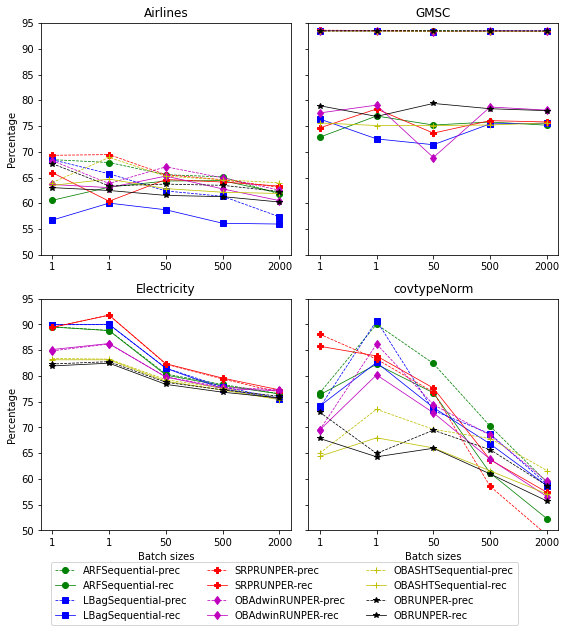

In [264]:
#by default, chart is generated with markers
#the modifier tables outputs the tables used for each serie of the chart
gen_chart(df, tables=True)